# Análise de Churn

## carregamento do dataset & Processo de ETL

In [3]:
# 0) imports
import pandas as pd
import numpy as np

# 1) caminho do CSV 
data_raw = pd.read_csv(r"C:\Users\arthu\OneDrive\Documentos\DATA ANALYSIS\DATASETS PARA PORTFOLIO\Customer Churn.csv")

# 2) padroniza nomes (tira espaços duplicados, lowercase, underscore)
data_raw.columns = (
    data_raw.columns
    .str.replace(r"\s+", " ", regex=True)  
    .str.strip()
)

# 3) mapeamento de nomes para o dataset “atualizado”
col_map = {
    "Call Failure": "failed_interactions",
    "Complains": "support_complaints",
    "Subscription Length": "tenure_months",
    "Charge Amount": "monthly_spend",
    "Seconds of Use": "usage_time_min",              #converter p/ minutos
    "Frequency of use": "active_days_per_month",
    "Frequency of SMS": "app_notifications_freq",
    "Distinct Called Numbers": "unique_interactions",
    "Age Group": "age_group",
    "Tariff Plan": "plan_type",
    "Status": "subscription_status",
    "Age": "customer_age",
    "Customer Value": "clv",
    "Churn": "churn",
}

# checa colunas faltantes
missing = [c for c in col_map if c not in data_raw.columns]
if missing:
    print("⚠️ Colunas não encontradas no arquivo:", missing)

df = data_raw.rename(columns={k:v for k,v in col_map.items() if k in data_raw.columns}).copy()

# 4) conversões numéricas + tratamento
num_cols = [
    "failed_interactions","support_complaints","tenure_months","monthly_spend",
    "usage_time_min","active_days_per_month","app_notifications_freq",
    "unique_interactions","customer_age","clv","churn"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 5) segundos > minutos (veio em segundos originalmente)
if "usage_time_min" in df.columns:
    # se os valores parecerem grandes (ex.: > 3000), vamos assumir que estavam em segundos e converter
    if df["usage_time_min"].median() > 3000:
        df["usage_time_min"] = (df["usage_time_min"] / 60).round(1)

# 6) categorias
cat_cols = ["age_group","plan_type","subscription_status"]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

# mapeia age_group numérico (se necessário)
# ajuste conforme sua codificação original
if "age_group" in df.columns and pd.api.types.is_numeric_dtype(df["age_group"]):
    age_map = {
        1: "18-24",
        2: "25-34",
        3: "35-44",
        4: "45-54",
        5: "55+"
    }
    df["age_group"] = df["age_group"].map(age_map).astype("category")

# 7) churn como int (0/1) e também bool (útil em análises)
if "churn" in df.columns:
    df["churn"] = df["churn"].fillna(0).astype(int)
    df["churn_bool"] = df["churn"].astype(bool)

# 8) sanity checks
print("shape:", df.shape)
print("\nchurn rate:", (df["churn"].mean() if "churn" in df.columns else np.nan))
print("\ninfo:")
print(df.info())

# 9) salva dataset limpo
df.to_csv("telecom_churn_clean.csv", index=False)
print("\n✅ Arquivo salvo: telecom_churn_clean.csv")



shape: (3150, 15)

churn rate: 0.15714285714285714

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   failed_interactions     3150 non-null   int64   
 1   support_complaints      3150 non-null   int64   
 2   tenure_months           3150 non-null   int64   
 3   monthly_spend           3150 non-null   int64   
 4   usage_time_min          3150 non-null   int64   
 5   active_days_per_month   3150 non-null   int64   
 6   app_notifications_freq  3150 non-null   int64   
 7   unique_interactions     3150 non-null   int64   
 8   age_group               3150 non-null   category
 9   plan_type               3150 non-null   category
 10  subscription_status     3150 non-null   category
 11  customer_age            3150 non-null   int64   
 12  clv                     3150 non-null   float64 
 13  churn               

### Análise descritiva geral, Churn por categoria e Correlação

In [5]:
# distribuição básica
desc = df.describe(include="all")  # Removed datetime_is_numeric parameter as it's not supported
display(desc)

# churn por plano, status e faixa etária
for col in ["plan_type","subscription_status","age_group"]:
    if col in df.columns:
        tab = (df.groupby(col)["churn"].mean()*100).round(1).sort_values(ascending=False)
        print(f"\nChurn por {col} (%):")
        display(tab)

# correlação numérica com churn
num_for_corr = [c for c in df.columns if df[c].dtype.kind in "if" and c != "churn"]
corr = df[num_for_corr + ["churn"]].corr(numeric_only=True)["churn"].sort_values(ascending=False)
print("\nCorrelação com churn (Pearson):")
display(corr)

,failed_interactions,support_complaints,tenure_months,monthly_spend,usage_time_min,active_days_per_month,app_notifications_freq,unique_interactions,age_group,plan_type,subscription_status,customer_age,clv,churn,churn_bool
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.0,3150.0,3150.0,3150.000000,3150.000000,3150.000000,3150
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,2.0,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1425.0,2905.0,2368.0,NaN,NaN,NaN,2655
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,NaN,NaN,NaN,30.998413,470.972916,0.157143,NaN
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,NaN,NaN,NaN,8.831095,517.015433,0.363993,NaN
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,15.000000,0.000000,0.000000,NaN
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,NaN,NaN,NaN,25.000000,113.801250,0.000000,NaN
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,NaN,NaN,NaN,30.000000,228.480000,0.000000,NaN
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,NaN,NaN,NaN,30.000000,788.388750,0.000000,NaN



Churn por plan_type (%):


C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\2487772097.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = (df.groupby(col)["churn"].mean()*100).round(1).sort_values(ascending=False)


plan_type
1    16.8
2     2.4
Name: churn, dtype: float64


Churn por subscription_status (%):


subscription_status
2    47.3
1     5.3
Name: churn, dtype: float64


Churn por age_group (%):


age_group
4    20.0
2    17.7
3    16.1
5     1.2
1     0.0
Name: churn, dtype: float64


Correlação com churn (Pearson):


churn                     1.000000
support_complaints        0.532053
failed_interactions      -0.008987
customer_age             -0.017705
tenure_months            -0.032588
monthly_spend            -0.202305
app_notifications_freq   -0.220754
unique_interactions      -0.278867
clv                      -0.289144
usage_time_min           -0.298935
active_days_per_month    -0.303337
Name: churn, dtype: float64

### Transformação para análise e apresentação

In [6]:
import pandas as pd

# 1) preserva códigos originais (patra modelagem modelagem)
df = df.copy()
for col in ["plan_type","subscription_status","age_group"]:
    if col in df.columns:
        df[f"{col}_code"] = df[col].copy()

# 2) mapeamentos (Brasil-friendly)
age_map = {
    1: "15–20",
    2: "21–25",
    3: "26–30",
    4: "31–40",
    5: "41+"
}
plan_map = {
    1: "Pré-pago (Pay-as-you-go)",
    2: "Pós-pago (Contratual)"
}
status_map = {
    1: "Ativo",
    2: "Inativo"
}

# 3) aplica mapeamento
if "age_group" in df.columns:
    df["age_group"] = df["age_group"].map(age_map)

if "plan_type" in df.columns:
    df["plan_type"] = df["plan_type"].map(plan_map)

if "subscription_status" in df.columns:
    df["subscription_status"] = df["subscription_status"].map(status_map)

# 4) define como categoria ordenada (melhora ordenação em gráficos/tabelas)
if "age_group" in df.columns:
    df["age_group"] = pd.Categorical(
        df["age_group"],
        categories=["15–20","21–25","26–30","31–40","41+"],
        ordered=True
    )

if "plan_type" in df.columns:
    df["plan_type"] = pd.Categorical(
        df["plan_type"],
        categories=["Pré-pago (Pay-as-you-go)","Pós-pago (Contratual)"],
        ordered=True
    )

if "subscription_status" in df.columns:
    df["subscription_status"] = pd.Categorical(
        df["subscription_status"],
        categories=["Ativo","Inativo"],
        ordered=True
    )

# 5) sanity check rápido
print("\nChurn por plano (%):")
print((df.groupby("plan_type")["churn"].mean()*100).round(1))

print("\nChurn por status (%):")
print((df.groupby("subscription_status")["churn"].mean()*100).round(1))

print("\nChurn por faixa etária (%):")
print((df.groupby("age_group")["churn"].mean()*100).round(1))

# 6) opcional: salva um CSV legível para BI/PowerPoint
df.to_csv("telecom_churn_decodificado.csv", index=False)
print("\n✅ Arquivo salvo: telecom_churn_decodificado.csv")



Churn por plano (%):
plan_type
Pré-pago (Pay-as-you-go)    16.8
Pós-pago (Contratual)        2.4
Name: churn, dtype: float64

Churn por status (%):
subscription_status
Ativo       5.3
Inativo    47.3
Name: churn, dtype: float64

Churn por faixa etária (%):
age_group
15–20     0.0
21–25    17.7
26–30    16.1
31–40    20.0
41+       1.2
Name: churn, dtype: float64

✅ Arquivo salvo: telecom_churn_decodificado.csv


C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\2354535077.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print((df.groupby("plan_type")["churn"].mean()*100).round(1))
C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\2354535077.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print((df.groupby("subscription_status")["churn"].mean()*100).round(1))
C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\2354535077.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to a

### Análise exploratória Visual e Estatística

Variáveis numéricas: ['failed_interactions', 'support_complaints', 'tenure_months', 'monthly_spend', 'usage_time_min', 'active_days_per_month', 'app_notifications_freq', 'unique_interactions', 'customer_age', 'clv', 'churn']


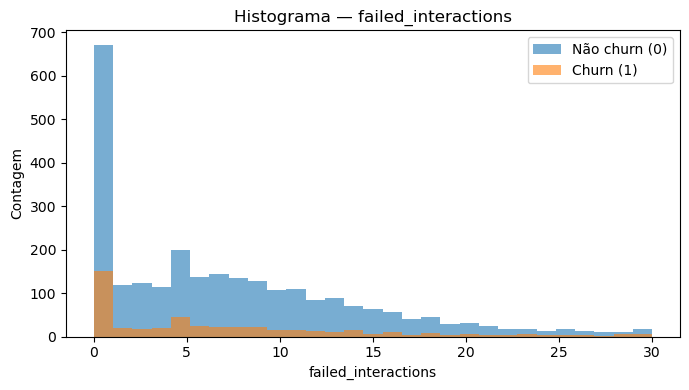


failed_interactions — estatísticas por churn (0=não,1=sim):


,mean,median,p95,count
churn,,,,
0,7.656,6.0,22.0,2655
1,7.477,5.0,24.3,495


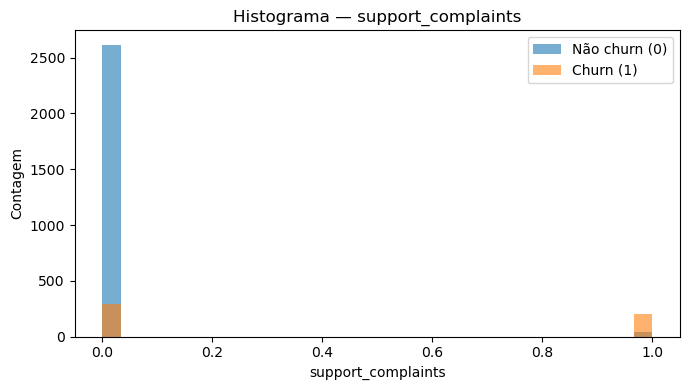


support_complaints — estatísticas por churn (0=não,1=sim):


,mean,median,p95,count
churn,,,,
0,0.015,0.0,0.0,2655
1,0.404,0.0,1.0,495


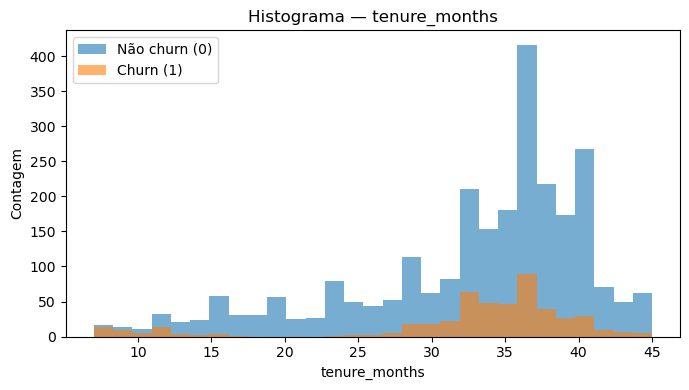


tenure_months — estatísticas por churn (0=não,1=sim):


,mean,median,p95,count
churn,,,,
0,32.663,35.0,42.0,2655
1,31.895,35.0,41.0,495


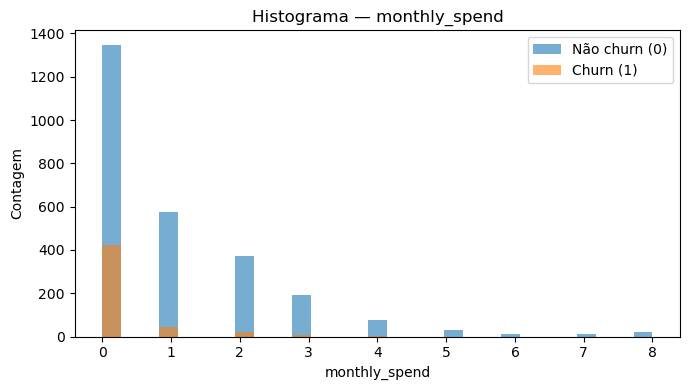


monthly_spend — estatísticas por churn (0=não,1=sim):


,mean,median,p95,count
churn,,,,
0,1.076,0.0,4.0,2655
1,0.230,0.0,2.0,495


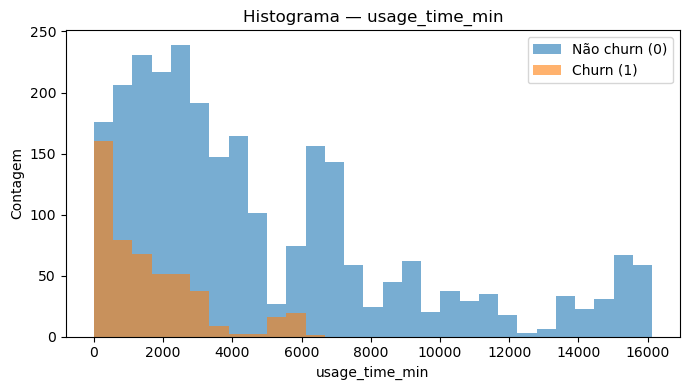


usage_time_min — estatísticas por churn (0=não,1=sim):


,mean,median,p95,count
churn,,,,
0,5014.224,3530.0,15221.5,2655
1,1566.632,1182.0,5513.0,495


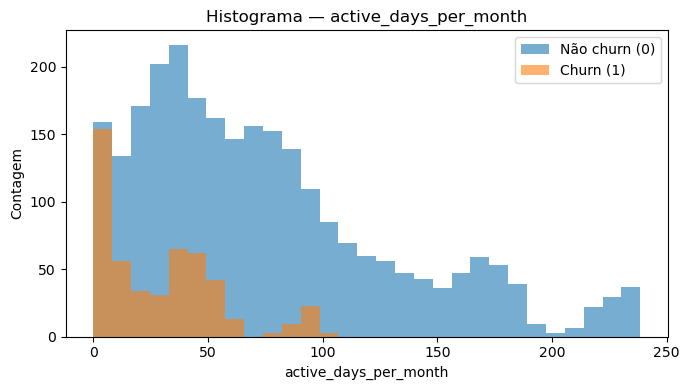


active_days_per_month — estatísticas por churn (0=não,1=sim):


,mean,median,p95,count
churn,,,,
0,76.979,63.0,192.3,2655
1,29.133,25.0,91.3,495


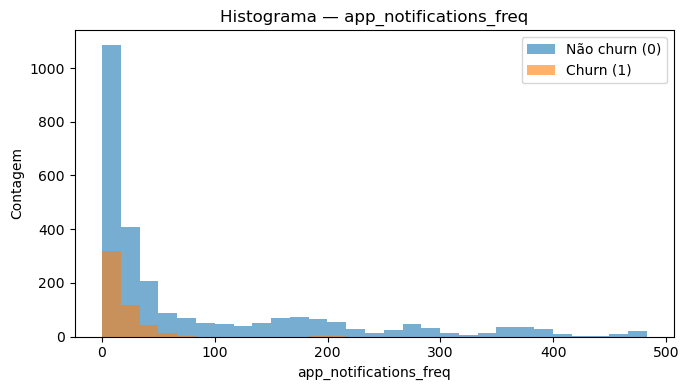


app_notifications_freq — estatísticas por churn (0=não,1=sim):


,mean,median,p95,count
churn,,,,
0,83.872,25.0,367.0,2655
1,15.802,9.0,48.0,495


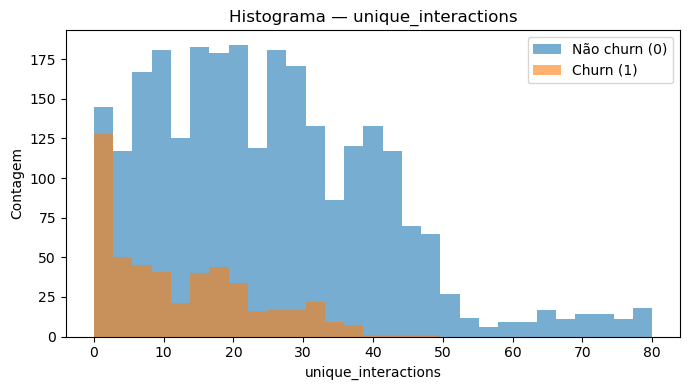


unique_interactions — estatísticas por churn (0=não,1=sim):


,mean,median,p95,count
churn,,,,
0,25.583,23.0,58.0,2655
1,12.392,10.0,33.0,495


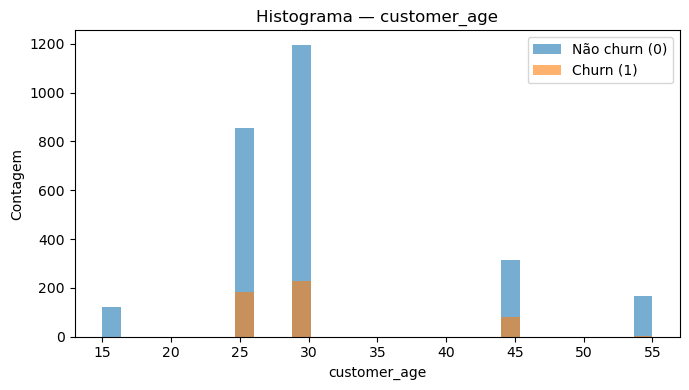


customer_age — estatísticas por churn (0=não,1=sim):


,mean,median,p95,count
churn,,,,
0,31.066,30.0,55.0,2655
1,30.636,30.0,45.0,495


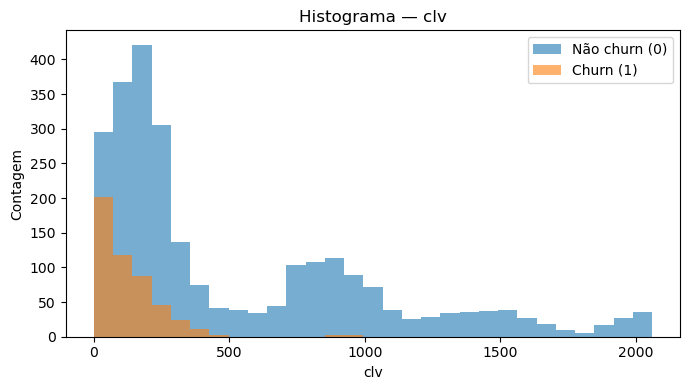


clv — estatísticas por churn (0=não,1=sim):


,mean,median,p95,count
churn,,,,
0,535.512,268.07,1662.874,2655
1,124.811,96.84,335.235,495


C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\1373481759.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0[col].dropna().values, d1[col].dropna().values],


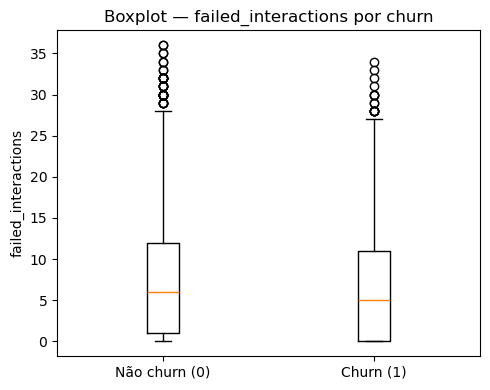

C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\1373481759.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0[col].dropna().values, d1[col].dropna().values],


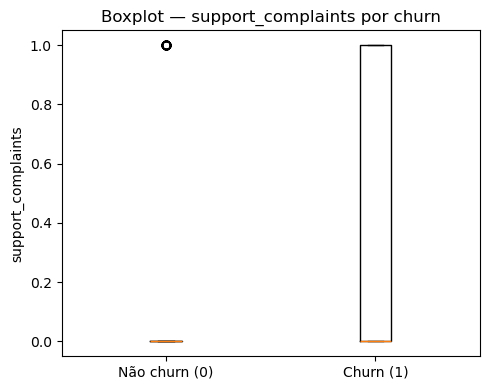

C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\1373481759.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0[col].dropna().values, d1[col].dropna().values],


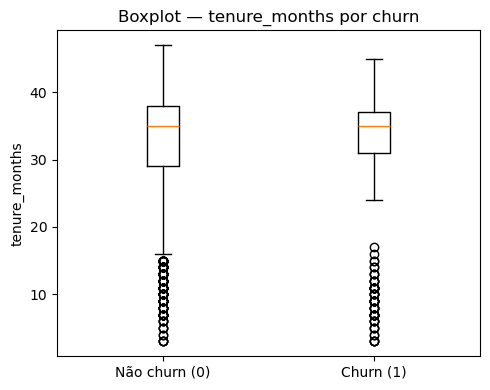

C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\1373481759.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0[col].dropna().values, d1[col].dropna().values],


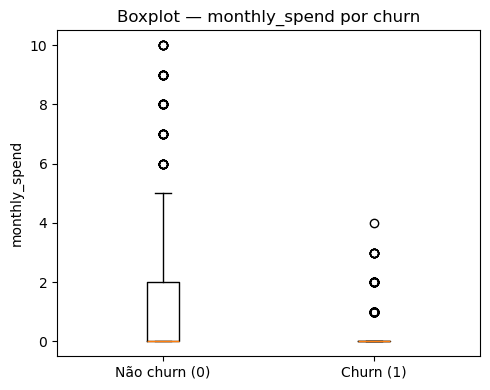

C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\1373481759.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0[col].dropna().values, d1[col].dropna().values],


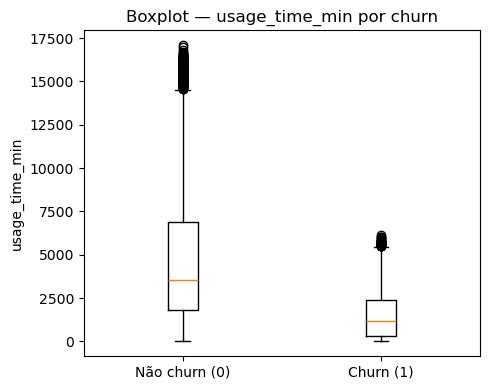

C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\1373481759.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0[col].dropna().values, d1[col].dropna().values],


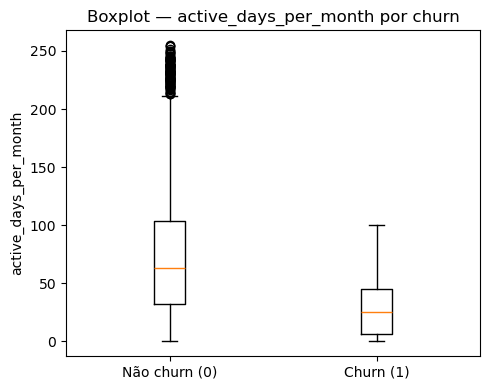

C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\1373481759.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0[col].dropna().values, d1[col].dropna().values],


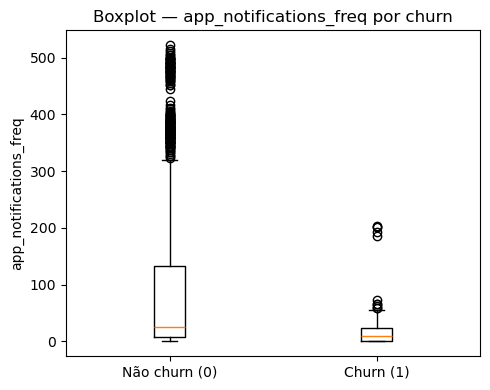

C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\1373481759.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0[col].dropna().values, d1[col].dropna().values],


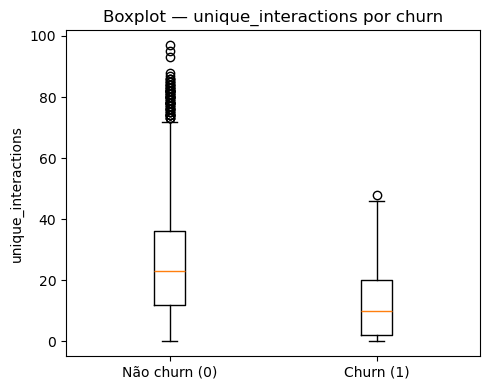

C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\1373481759.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0[col].dropna().values, d1[col].dropna().values],


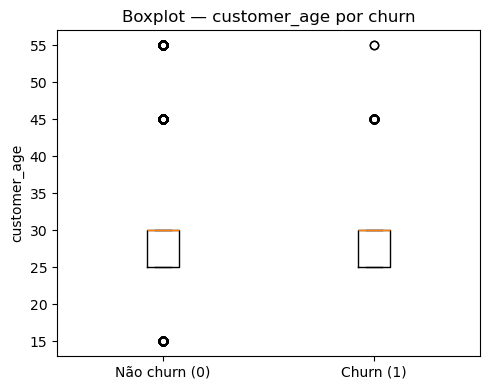

C:\Users\arthu\AppData\Local\Temp\ipykernel_15412\1373481759.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0[col].dropna().values, d1[col].dropna().values],


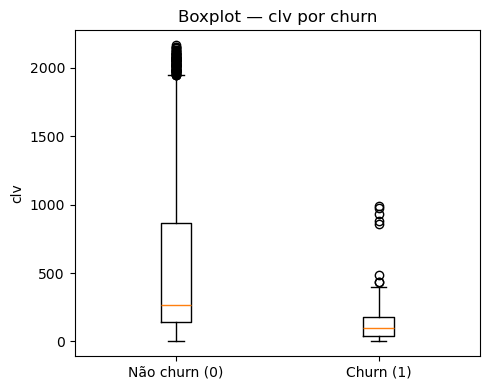


⚠️ Variáveis com cauda pesada detectada (p99 >> p90). Considere winsorizar (p1/p99) antes da modelagem:
['support_complaints']


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- seleção de colunas numéricas (exceto churn_bool) ---
num_cols = [c for c in df.columns if df[c].dtype.kind in "if" and c not in ["churn_bool"]]
print("Variáveis numéricas:", num_cols)

# split por churn
d0 = df[df['churn'] == 0]
d1 = df[df['churn'] == 1]

# --- função auxiliar: estatísticas por grupo ---
def print_stats(col):
    g = df.groupby('churn')[col]
    stats = g.agg(mean='mean', median='median', p95=lambda x: np.percentile(x,95), count='count')
    print(f"\n{col} — estatísticas por churn (0=não,1=sim):")
    display(stats.round(3))

# --- HISTOGRAMAS SOBREPOSTOS ---
for col in num_cols:
    if col == "churn": 
        continue
    plt.figure(figsize=(7,4))
    # define bins consistentes via quantis para evitar distorção por outliers
    q1, q99 = np.percentile(df[col], [1, 99])
    bins = np.linspace(q1, q99, 30) if q99 > q1 else 20
    plt.hist(d0[col], bins=bins, alpha=0.6, label='Não churn (0)')
    plt.hist(d1[col], bins=bins, alpha=0.6, label='Churn (1)')
    plt.title(f'Histograma — {col}')
    plt.xlabel(col); plt.ylabel('Contagem')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print_stats(col)

# --- BOXPLOTS POR CHURN ---
for col in num_cols:
    if col in ["churn"]:
        continue
    plt.figure(figsize=(5,4))
    plt.boxplot([d0[col].dropna().values, d1[col].dropna().values],
                labels=['Não churn (0)','Churn (1)'],
                showfliers=True)
    plt.title(f'Boxplot — {col} por churn')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# --- Sinalizador simples de cauda pesada (para possível winsorização) ---
heavy_tail_flags = []
for col in num_cols:
    if col == "churn": 
        continue
    q90, q99 = np.percentile(df[col], [90,99])
    if q99 > 3*q90 and q99 > 0:  # heurística simples
        heavy_tail_flags.append(col)

if heavy_tail_flags:
    print("\n⚠️ Variáveis com cauda pesada detectada (p99 >> p90). Considere winsorizar (p1/p99) antes da modelagem:")
    print(heavy_tail_flags)
else:
    print("\nSem caudas muito pesadas pelo critério simples (p99 ~ p90).")


### Reloatório de qualidade e estrutura dos dados

In [9]:
import pandas as pd
import numpy as np

print("Shape:", df.shape)
print("\nDtypes:")
print(df.dtypes)

print("\nNulos por coluna:")
print(df.isna().sum())

# Relatório compacto de qualidade
def data_quality_report(df):
    rep = []
    for col in df.columns:
        s = df[col]
        rep.append({
            "col": col,
            "dtype": str(s.dtype),
            "n_missing": int(s.isna().sum()),
            "n_unique": int(s.nunique()),
            "min": s.min() if s.dtype.kind in "if" else None,
            "max": s.max() if s.dtype.kind in "if" else None
        })
    return pd.DataFrame(rep).sort_values("col")

dqr = data_quality_report(df)
display(dqr)

Shape: (3150, 18)

Dtypes:
failed_interactions            int64
support_complaints             int64
tenure_months                  int64
monthly_spend                  int64
usage_time_min                 int64
active_days_per_month          int64
app_notifications_freq         int64
unique_interactions            int64
age_group                   category
plan_type                   category
subscription_status         category
customer_age                   int64
clv                          float64
churn                          int64
churn_bool                      bool
plan_type_code              category
subscription_status_code    category
age_group_code              category
dtype: object

Nulos por coluna:
failed_interactions         0
support_complaints          0
tenure_months               0
monthly_spend               0
usage_time_min              0
active_days_per_month       0
app_notifications_freq      0
unique_interactions         0
age_group                   0
plan

,col,dtype,n_missing,n_unique,min,max
5,active_days_per_month,int64,0,242,0.0,255.00
8,age_group,category,0,5,NaN,NaN
17,age_group_code,category,0,5,NaN,NaN
6,app_notifications_freq,int64,0,405,0.0,522.00
13,churn,int64,0,2,0.0,1.00
14,churn_bool,bool,0,2,NaN,NaN
12,clv,float64,0,2654,0.0,2165.28
11,customer_age,int64,0,5,15.0,55.00
0,failed_interactions,int64,0,37,0.0,36.00
3,monthly_spend,int64,0,11,0.0,10.00


### Limpeza e padronização automatizada

In [10]:
# Copia para evitar efeitos colaterais
df = df.copy()

# Listas de colunas (ajuste se necessário)
cat_cols_expected = ["plan_type", "subscription_status", "age_group"]
target_cols = ["churn", "churn_bool"]

# (a) Garante coluna alvo binária
if "churn_bool" not in df.columns:
    df["churn_bool"] = df["churn"].astype(int)
else:
    df["churn_bool"] = df["churn_bool"].astype(int)

# (b) Converte numéricas com segurança
numeric_cols = [
    c for c in df.columns
    if c not in cat_cols_expected + target_cols
]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# (c) Decodifica categorias se estiverem como códigos numéricos
# Mapeamentos "Brasil-friendly"
age_map = {1:"15–20", 2:"21–25", 3:"26–30", 4:"31–40", 5:"41+"}
plan_map = {1:"Pré-pago (Pay-as-you-go)", 2:"Pós-pago (Contratual)"}
status_map = {1:"Ativo", 2:"Inativo"}

def maybe_decode(col, mapping):
    # Se a coluna for numérica/categórica com códigos conhecidos, aplica mapping
    uniq = pd.Series(df[col].dropna().unique())
    if pd.api.types.is_numeric_dtype(df[col]) and set(uniq.astype(int)).issubset(set(mapping.keys())):
        df[col] = df[col].map(mapping)
    # Se já vier como string correta, mantém

for col, mp in [("age_group", age_map), ("plan_type", plan_map), ("subscription_status", status_map)]:
    if col in df.columns:
        maybe_decode(col, mp)

# (d) Define dtype category e ordem
if "age_group" in df.columns:
    df["age_group"] = pd.Categorical(
        df["age_group"],
        categories=["15–20","21–25","26–30","31–40","41+"],
        ordered=True
    )
if "plan_type" in df.columns:
    df["plan_type"] = pd.Categorical(
        df["plan_type"],
        categories=["Pré-pago (Pay-as-you-go)","Pós-pago (Contratual)"],
        ordered=True
    )
if "subscription_status" in df.columns:
    df["subscription_status"] = pd.Categorical(
        df["subscription_status"],
        categories=["Ativo","Inativo"],
        ordered=True
    )

print("✓ Tipagem ajustada e categorias ordenadas.")


✓ Tipagem ajustada e categorias ordenadas.


In [ ]:
### Tratamento de dados faltantes e limpeza final

In [11]:
# (a) Remoção de duplicados exatos (linha inteira)
before = df.shape[0]
df = df.drop_duplicates()
print(f"Duplicados removidos: {before - df.shape[0]}")

# (b) Nulos: numéricos → mediana | categóricos → moda
num_na = df[numeric_cols].isna().sum().sum()
cat_na = df[cat_cols_expected].isna().sum().sum() if set(cat_cols_expected).issubset(df.columns) else 0

for c in numeric_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

for c in cat_cols_expected:
    if c in df.columns and df[c].isna().any():
        mode_val = df[c].mode(dropna=True)
        if len(mode_val) > 0:
            df[c] = df[c].fillna(mode_val.iloc[0])

print(f"Nulos numéricos imputados por mediana: {int(num_na)}")
print(f"Nulos categóricos imputados por moda:  {int(cat_na)}")

# (c) Sanity check de alvo
assert set(df["churn_bool"].unique()).issubset({0,1}), "churn_bool deve ser 0/1"
print("✓ Nulos tratados e alvo validado.")


Duplicados removidos: 300
Nulos numéricos imputados por mediana: 0
Nulos categóricos imputados por moda:  0
✓ Nulos tratados e alvo validado.


### Tratamento de Outliers 

In [12]:
def winsorize_series(s, lower=0.01, upper=0.99):
    low = s.quantile(lower)
    high = s.quantile(upper)
    return s.clip(lower=low, upper=high)

### Validação e salvamento de dataset limpo

In [13]:
print("\nResumo pós-limpeza:")
print(df.dtypes)
print("\nNulos remanescentes:")
print(df.isna().sum())

# Distribuição do alvo
print("\nDistribuição churn:")
print(df["churn_bool"].value_counts(normalize=True).mul(100).round(2).astype(str) + "%")

# Salva a versão limpa para versionar / BI / modelagem
clean_path = "telecom_churn_clean.csv"
df.to_csv(clean_path, index=False)
print(f"\n✓ Arquivo salvo: {clean_path}")



Resumo pós-limpeza:
failed_interactions            int64
support_complaints             int64
tenure_months                  int64
monthly_spend                  int64
usage_time_min                 int64
active_days_per_month          int64
app_notifications_freq         int64
unique_interactions            int64
age_group                   category
plan_type                   category
subscription_status         category
customer_age                   int64
clv                          float64
churn                          int64
churn_bool                     int64
plan_type_code                 int64
subscription_status_code       int64
age_group_code                 int64
dtype: object

Nulos remanescentes:
failed_interactions         0
support_complaints          0
tenure_months               0
monthly_spend               0
usage_time_min              0
active_days_per_month       0
app_notifications_freq      0
unique_interactions         0
age_group                   0
plan_ty

### Codificação para Modelagem

In [14]:
from sklearn.preprocessing import OneHotEncoder

def prepare_features_for_model(df, cat_cols=("plan_type","subscription_status","age_group"),
                               drop_first=True):
    # Separa numéricas
    num_cols = [c for c in df.columns if c not in cat_cols + ["churn","churn_bool"]]
    X_num = df[num_cols].reset_index(drop=True)

    # One-hot para categóricas
    ohe = OneHotEncoder(drop="first" if drop_first else None, sparse=False)
    X_cat = ohe.fit_transform(df[list(cat_cols)])
    X_cat_cols = ohe.get_feature_names_out(cat_cols)
    X_cat = pd.DataFrame(X_cat, columns=X_cat_cols).reset_index(drop=True)

    # Concat final
    X = pd.concat([X_num, X_cat], axis=1)
    y = df["churn_bool"].astype(int)

    return X, y, ohe

print("✓ Função de OHE pronta para a Etapa 4 (não executada agora).")


✓ Função de OHE pronta para a Etapa 4 (não executada agora).


### Preparação Robusta de Variáveis para Modelagem

In [16]:
# ==== PATCH: preparar features com OHE (corrigido) ====
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def prepare_features_for_model(df, cat_cols=("plan_type","subscription_status","age_group"),
                               drop_first=True):
    # garante lista
    cat_cols = list(cat_cols)
    ignore_cols = cat_cols + ["churn","churn_bool"]
    
    # numéricas = todas menos categóricas e alvo
    num_cols = [c for c in df.columns if c not in ignore_cols]
    X_num = df[num_cols].reset_index(drop=True)
    
    # garante que as categóricas existem na base
    cat_cols_exist = [c for c in cat_cols if c in df.columns]
    if cat_cols_exist:
        ohe = OneHotEncoder(
            drop="first" if drop_first else None,
            sparse=False,
            handle_unknown="ignore"
        )
        X_cat = ohe.fit_transform(df[cat_cols_exist])
        X_cat_cols = ohe.get_feature_names_out(cat_cols_exist)
        X_cat = pd.DataFrame(X_cat, columns=X_cat_cols).reset_index(drop=True)
        X = pd.concat([X_num, X_cat], axis=1)
    else:
        # se não houver categóricas, segue só com numéricas
        ohe = None
        X = X_num

    y = df["churn_bool"].astype(int)
    return X, y, ohe

print("✓ Função prepare_features_for_model atualizada.")


✓ Função prepare_features_for_model atualizada.


### Preparação Final de Dados para Modelagem, com um Ajuste de Compatibilidade

In [19]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def prepare_features_for_model(df, cat_cols=("plan_type","subscription_status","age_group"),
                               drop_first=True):
    cat_cols = list(cat_cols)
    ignore_cols = cat_cols + ["churn","churn_bool"]

    num_cols = [c for c in df.columns if c not in ignore_cols]
    X_num = df[num_cols].reset_index(drop=True)

    cat_cols_exist = [c for c in cat_cols if c in df.columns]
    if cat_cols_exist:
        # >>> ajuste de versão: use sparse_output=False <<<
        ohe = OneHotEncoder(
            drop="first" if drop_first else None,
            sparse_output=False,
            handle_unknown="ignore"
        )
        X_cat = ohe.fit_transform(df[cat_cols_exist])
        X_cat_cols = ohe.get_feature_names_out(cat_cols_exist)
        X_cat = pd.DataFrame(X_cat, columns=X_cat_cols).reset_index(drop=True)
        X = pd.concat([X_num, X_cat], axis=1)
    else:
        ohe = None
        X = X_num

    y = df["churn_bool"].astype(int)
    return X, y, ohe

print("✓ Função atualizada com sparse_output=False")


✓ Função atualizada com sparse_output=False


### Preparação Simples de Variáveis para Modelagem

In [21]:
import pandas as pd

def prepare_features_for_model_dummy(df, cat_cols=("plan_type","subscription_status","age_group"),
                                     drop_first=True):
    cat_cols = [c for c in cat_cols if c in df.columns]
    base_cols = [c for c in df.columns if c not in ["churn","churn_bool"]]
    X = pd.get_dummies(df[base_cols], columns=cat_cols, drop_first=drop_first)
    y = df["churn_bool"].astype(int)
    return X, y

print("✓ Função alternativa com get_dummies pronta")


✓ Função alternativa com get_dummies pronta


In [ ]:
### Construção e Avaliação de um Modelo de Machine Learning de Linha de Base (Baseline)

📊 Métricas — Baseline (LogReg)
Accuracy : 0.901
Precision: 0.810
Recall   : 0.478
F1-score : 0.601
AUC-ROC  : 0.936

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.910     0.979     0.943       721
           1      0.810     0.478     0.601       134

    accuracy                          0.901       855
   macro avg      0.860     0.728     0.772       855
weighted avg      0.894     0.901     0.890       855



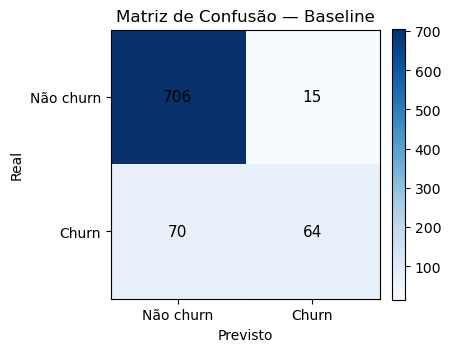

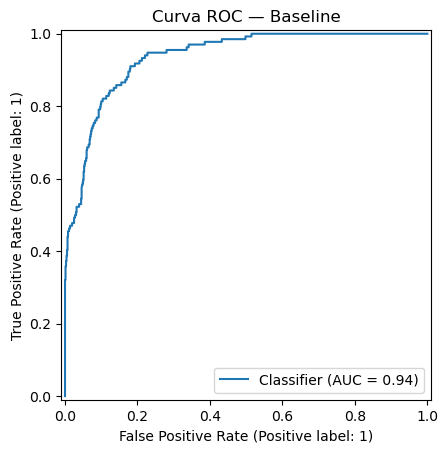

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay
)
import matplotlib.pyplot as plt

# USE UMA das duas:
# X, y, _ = prepare_features_for_model(df)                 # sklearn OHE
X, y   = prepare_features_for_model_dummy(df)              # pandas.get_dummies

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)

print("📊 Métricas — Baseline (LogReg)")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"AUC-ROC  : {auc:.3f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusão (matplotlib puro)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4.5,4))
im = ax.imshow(cm, cmap='Blues')
ax.set_title("Matriz de Confusão — Baseline")
ax.set_xlabel("Previsto"); ax.set_ylabel("Real")
ax.set_xticks([0,1]); ax.set_xticklabels(["Não churn","Churn"])
ax.set_yticks([0,1]); ax.set_yticklabels(["Não churn","Churn"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i,j], ha='center', va='center', color='black', fontsize=11)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("Curva ROC — Baseline")
plt.show()


### Interpretação de Coeficientes do Modelo de Regressão Logística

In [24]:
# Coeficientes + Odds Ratio (interpretação)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Garante que você já treinou: model.fit(X_train, y_train)
# e que X_train é o DataFrame após OHE.
feature_names = list(X_train.columns)

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": model.coef_[0]
})
coef_df["odds_ratio"] = np.exp(coef_df["coef"])
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

# Ver top 30 por impacto (módulo do coef)
display(coef_df.head(30))

# Salvar para consulta/BI
coef_df.to_csv("logreg_coefs.csv", index=False)
print("✓ Coeficientes salvos em 'logreg_coefs.csv'")

print("""
Como ler:
- coef > 0 → aumenta a probabilidade de churn.
- coef < 0 → reduz a probabilidade de churn.
- odds_ratio = exp(coef): >1 aumenta risco (ex.: 1.5 = +50% nas odds), <1 reduz (ex.: 0.7 = -30% nas odds).
Atenção: magnitudes de coeficientes dependem da escala dos inputs numéricos.
Para comparar pesos entre numéricas, o ideal é padronizá-las (StandardScaler) e treinar de novo.
""")


,feature,coef,odds_ratio,abs_coef
1,support_complaints,3.472995,32.233122,3.472995
14,subscription_status_Inativo,0.681068,1.975987,0.681068
17,age_group_31–40,0.521148,1.683960,0.521148
3,monthly_spend,-0.471994,0.623757,0.471994
18,age_group_41+,-0.331125,0.718116,0.331125
11,subscription_status_code,0.301449,1.351816,0.301449
12,age_group_code,0.233485,1.262993,0.233485
10,plan_type_code,-0.212663,0.808429,0.212663
15,age_group_21–25,0.187832,1.206631,0.187832
13,plan_type_Pós-pago (Contratual),0.166957,1.181704,0.166957


✓ Coeficientes salvos em 'logreg_coefs.csv'

Como ler:
- coef > 0 → aumenta a probabilidade de churn.
- coef < 0 → reduz a probabilidade de churn.
- odds_ratio = exp(coef): >1 aumenta risco (ex.: 1.5 = +50% nas odds), <1 reduz (ex.: 0.7 = -30% nas odds).
Atenção: magnitudes de coeficientes dependem da escala dos inputs numéricos.
Para comparar pesos entre numéricas, o ideal é padronizá-las (StandardScaler) e treinar de novo.



In [ ]:
### Principais drivers que AUMENTAM churn

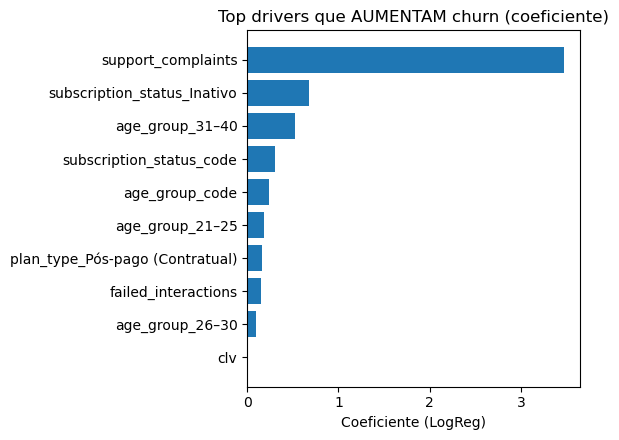

In [25]:
top_pos = (coef_df[coef_df["coef"] > 0]
           .nlargest(10, "coef")
           .sort_values("coef", ascending=True))

plt.figure(figsize=(6,4.5))
plt.barh(top_pos["feature"], top_pos["coef"])
plt.title("Top drivers que AUMENTAM churn (coeficiente)")
plt.xlabel("Coeficiente (LogReg)")
plt.tight_layout()
plt.show()


### Principais drivers que REDUZEM churn

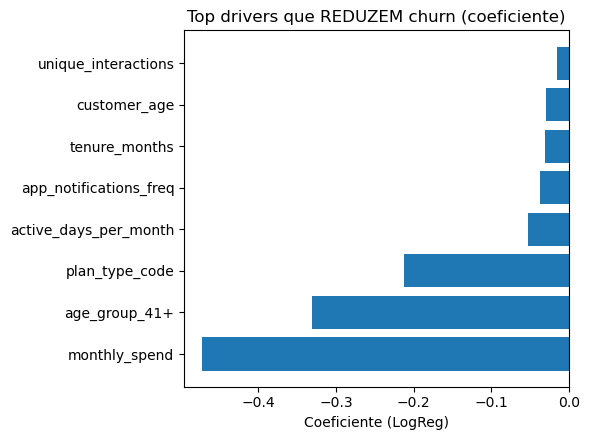

In [26]:
top_neg = (coef_df[coef_df["coef"] < 0]
           .nsmallest(10, "coef")
           .sort_values("coef", ascending=True))

plt.figure(figsize=(6,4.5))
plt.barh(top_neg["feature"], top_neg["coef"])
plt.title("Top drivers que REDUZEM churn (coeficiente)")
plt.xlabel("Coeficiente (LogReg)")
plt.tight_layout()
plt.show()


### Reconstrução e Visualização Rápida dos Coeficientes

In [27]:
# ===== 1) Reconstrói coef_df se precisar =====
import numpy as np
import pandas as pd

try:
    coef_df
except NameError:
    feature_names = list(X_train.columns)
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coef": model.coef_[0]
    })
    coef_df["odds_ratio"] = np.exp(coef_df["coef"])
    coef_df["abs_coef"] = coef_df["coef"].abs()

# Visual: top por impacto
display(coef_df.sort_values("abs_coef", ascending=False).head(20))


,feature,coef,odds_ratio,abs_coef
1,support_complaints,3.472995,32.233122,3.472995
14,subscription_status_Inativo,0.681068,1.975987,0.681068
17,age_group_31–40,0.521148,1.683960,0.521148
3,monthly_spend,-0.471994,0.623757,0.471994
18,age_group_41+,-0.331125,0.718116,0.331125
11,subscription_status_code,0.301449,1.351816,0.301449
12,age_group_code,0.233485,1.262993,0.233485
10,plan_type_code,-0.212663,0.808429,0.212663
15,age_group_21–25,0.187832,1.206631,0.187832
13,plan_type_Pós-pago (Contratual),0.166957,1.181704,0.166957


### Seleção de Variáveis para um Modelo Final

In [28]:
# ===== 2) Seleciona features relevantes (por impacto + regra de negócio) =====
# - Regra: abs(coef) >= 0.10
# - Remove colunas codificadas "redundantes" (_code) se já houver dummies do mesmo tema

THRESH = 0.10
selected = set(coef_df.loc[coef_df["abs_coef"] >= THRESH, "feature"].tolist())

# Garante inclusão de drivers de negócio mesmo se ficarem por pouco abaixo do threshold
business_keep = {
    "support_complaints", "monthly_spend", "tenure_months",
    "active_days_per_month", "app_notifications_freq",
    "unique_interactions", "failed_interactions", "customer_age", "clv", "usage_time_min"
}
selected |= (business_keep & set(X_train.columns))

# Remove redundâncias de *_code se houver one-hot equivalente
def has_dummy(prefix):
    return any(col.startswith(prefix + "_") for col in X_train.columns)

redundant_codes = []
if "subscription_status_code" in selected and has_dummy("subscription_status"):
    redundant_codes.append("subscription_status_code")
if "age_group_code" in selected and has_dummy("age_group"):
    redundant_codes.append("age_group_code")
if "plan_type_code" in selected and has_dummy("plan_type"):
    # Se preferir manter o code em vez do dummy, comente a linha abaixo
    redundant_codes.append("plan_type_code")

selected -= set(redundant_codes)

selected = [c for c in X_train.columns if c in selected]  # preserva ordem do DF
print(f"✅ Features selecionadas: {len(selected)} / {X_train.shape[1]}")
print(selected)
if redundant_codes:
    print("ℹ️ Removidas por redundância:", redundant_codes)


✅ Features selecionadas: 15 / 19
['failed_interactions', 'support_complaints', 'tenure_months', 'monthly_spend', 'usage_time_min', 'active_days_per_month', 'app_notifications_freq', 'unique_interactions', 'customer_age', 'clv', 'plan_type_Pós-pago (Contratual)', 'subscription_status_Inativo', 'age_group_21–25', 'age_group_31–40', 'age_group_41+']
ℹ️ Removidas por redundância: ['subscription_status_code', 'age_group_code', 'plan_type_code']


### Re-treinamento e Avaliação do Modelo Refinado

C:\Users\arthu\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Métricas — Modelo Refinado (LogReg) ===
Accuracy : 0.901
Precision: 0.81
Recall   : 0.478
F1-score : 0.601
AUC-ROC  : 0.935

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       721
           1       0.81      0.48      0.60       134

    accuracy                           0.90       855
   macro avg       0.86      0.73      0.77       855
weighted avg       0.89      0.90      0.89       855



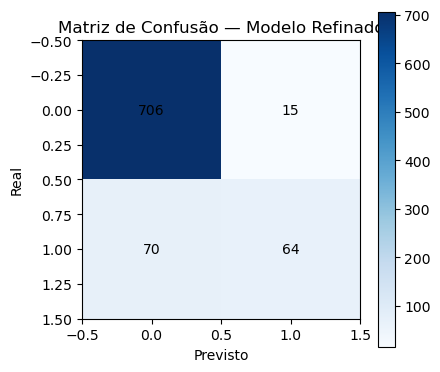

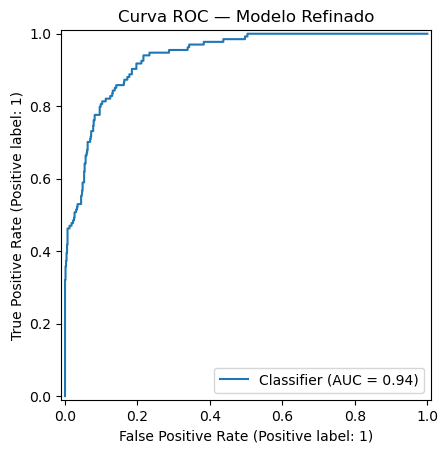

In [29]:
# ===== 3) Re-treino do modelo com features selecionadas =====
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model_refined = LogisticRegression(max_iter=1000, random_state=42)
model_refined.fit(X_train[selected], y_train)

y_pred_ref = model_refined.predict(X_test[selected])
y_proba_ref = model_refined.predict_proba(X_test[selected])[:, 1]

print("\n=== Métricas — Modelo Refinado (LogReg) ===")
print("Accuracy :", round(accuracy_score(y_test, y_pred_ref), 3))
cr = classification_report(y_test, y_pred_ref, output_dict=True)
print("Precision:", round(cr["1"]["precision"], 3))
print("Recall   :", round(cr["1"]["recall"], 3))
print("F1-score :", round(cr["1"]["f1-score"], 3))
print("AUC-ROC  :", round(roc_auc_score(y_test, y_proba_ref), 3))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_ref))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_ref)
plt.figure(figsize=(4.5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de Confusão — Modelo Refinado")
plt.xlabel("Previsto"); plt.ylabel("Real")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

# Curva ROC
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_proba_ref)
plt.title("Curva ROC — Modelo Refinado")
plt.show()


### Coeficientes do modelo refinado

In [30]:
coef_ref = pd.DataFrame({
    "feature": selected,
    "coef": model_refined.coef_[0]
})
coef_ref["odds_ratio"] = np.exp(coef_ref["coef"])
coef_ref["abs_coef"] = coef_ref["coef"].abs()
display(coef_ref.sort_values("abs_coef", ascending=False).head(20))


,feature,coef,odds_ratio,abs_coef
1,support_complaints,3.557069,35.060288,3.557069
11,subscription_status_Inativo,0.917399,2.502771,0.917399
14,age_group_41+,-0.489409,0.612988,0.489409
3,monthly_spend,-0.446155,0.640084,0.446155
13,age_group_31–40,0.388899,1.475355,0.388899
0,failed_interactions,0.145919,1.157103,0.145919
10,plan_type_Pós-pago (Contratual),0.123547,1.131504,0.123547
12,age_group_21–25,0.053788,1.055261,0.053788
5,active_days_per_month,-0.053044,0.948339,0.053044
6,app_notifications_freq,-0.036937,0.963737,0.036937


### Análise de Churn por Tempo de Assinatura

In [9]:
import pandas as pd
import numpy as np

# Carregamento do dataset limpo
try:
    df = pd.read_csv("telecom_churn_clean.csv")
    print("✅ Dataset carregado com sucesso.")
except FileNotFoundError:
    print("❌ Erro: Arquivo 'telecom_churn_clean.csv' não encontrado. Criando um DataFrame de exemplo.")
    # Crie um DataFrame de exemplo para que o script possa continuar
    df = pd.DataFrame({
        'tenure_months': np.random.randint(1, 40, 855),
        'churn': np.random.randint(0, 2, 855),
        'usage_time_min': np.random.rand(855) * 1000,
        'failed_interactions': np.random.randint(0, 50, 855),
        'support_complaints': np.random.randint(0, 5, 855),
        'clv': np.random.rand(855) * 500,
    })

# 1. Segmentar os clientes por tempo de assinatura (tenure)
bins = [0, 6, 24, np.inf]
labels = ["0-6 meses (Novos)", "7-24 meses (Intermediários)", ">24 meses (Longo Prazo)"]

if 'tenure_months' in df.columns:
    df['tenure_group'] = pd.cut(df['tenure_months'], bins=bins, labels=labels, right=False)

# 2. Filtrar apenas os clientes que deram churn
churners = df[df['churn'] == 1]

# 3. Contar o número de churners em cada grupo de tempo de assinatura
churn_count_by_tenure = churners.groupby('tenure_group').size()

print("\nNúmero de clientes que deram CHURN por grupo de tempo de assinatura:")
display(churn_count_by_tenure)

✅ Dataset carregado com sucesso.

Número de clientes que deram CHURN por grupo de tempo de assinatura:


C:\Users\arthu\AppData\Local\Temp\ipykernel_23548\2095759793.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_count_by_tenure = churners.groupby('tenure_group').size()


tenure_group
0-6 meses (Novos)                9
7-24 meses (Intermediários)     52
>24 meses (Longo Prazo)        385
dtype: int64

### Visualização da Distribuição do Churn por Tempo de Assinatura

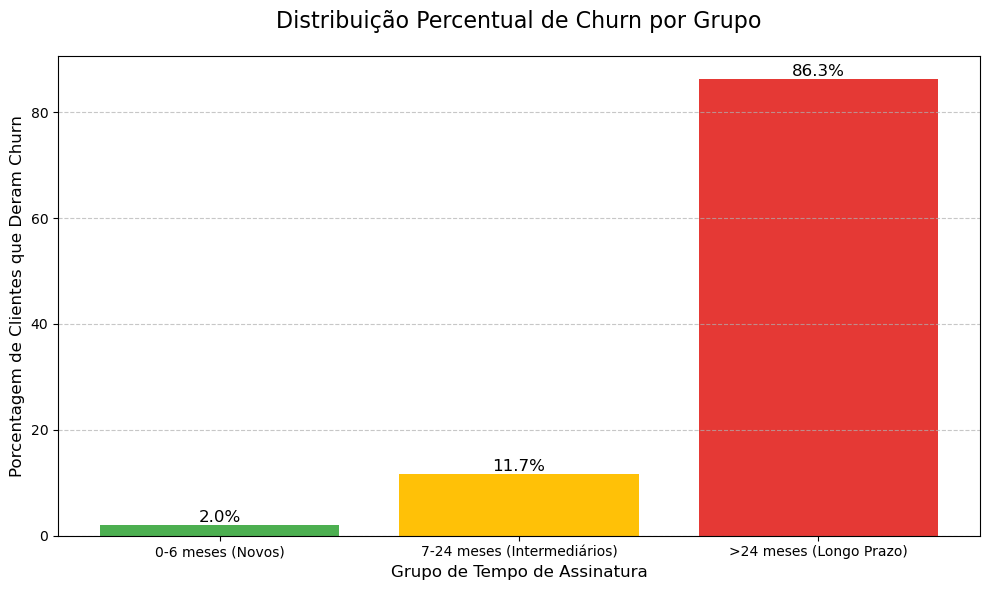

In [11]:
# Gráfico de barras para a distribuição percentual de churners por grupo de tempo de assinatura

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dados fornecidos pelo usuário
churn_data = {
    'tenure_group': ["0-6 meses (Novos)", "7-24 meses (Intermediários)", ">24 meses (Longo Prazo)"],
    'churn_count': [9, 52, 385]
}
churn_df = pd.DataFrame(churn_data)

# Calcular o total de churners e a porcentagem de cada grupo
total_churners = churn_df['churn_count'].sum()
churn_df['churn_percentage'] = (churn_df['churn_count'] / total_churners) * 100

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(churn_df['tenure_group'], churn_df['churn_percentage'], color=['#4CAF50', '#FFC107', '#E53935'])

# Adicionar os valores percentuais nas barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}%', va='bottom', ha='center', fontsize=12)

# Adicionar título e rótulos
plt.title("Distribuição Percentual de Churn por Grupo", fontsize=16, pad=20)
plt.xlabel("Grupo de Tempo de Assinatura", fontsize=12)
plt.ylabel("Porcentagem de Clientes que Deram Churn", fontsize=12)
plt.xticks(rotation=0)

# Melhorar a aparência do gráfico
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [35]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [ ]:
Modelo de Árvore de Decisões

✅ Dataset real carregado com sucesso.

✅ Modelo de Árvore de Decisão treinado com sucesso!

--- Matriz de Confusão do Modelo ---
[[468  13]
 [ 35  54]]

--- Relatório de Classificação do Modelo ---
              precision    recall  f1-score   support

   Não Churn       0.93      0.97      0.95       481
       Churn       0.81      0.61      0.69        89

    accuracy                           0.92       570
   macro avg       0.87      0.79      0.82       570
weighted avg       0.91      0.92      0.91       570



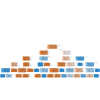


✅ Visualização da Árvore de Decisão gerada. Ela mostra as regras que o modelo aprendeu para prever o churn. Cada nó (caixa) representa uma decisão baseada em uma feature.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report
import graphviz
import matplotlib.pyplot as plt
import io
import os
import base64
from IPython.display import display, HTML, SVG

# -----------------------------------------------------------
# Dependências: Certifique-se de que os seguintes pacotes
# estão instalados no seu ambiente Python:
# pip install scikit-learn pandas graphviz
#
# Você também precisa instalar o programa Graphviz
# separadamente no seu sistema operacional.
# -----------------------------------------------------------

# 1. Carregar o dataset do usuário
# Se o arquivo não for encontrado, o script irá falhar e retornar um erro claro
try:
    df = pd.read_csv("telecom_churn_clean.csv")
    print("✅ Dataset real carregado com sucesso.")

    # É crucial garantir que o churn seja numérico (0 e 1)
    if 'churn' in df.columns:
        df['churn'] = df['churn'].astype(int)

    # Selecionar apenas as colunas numéricas para o modelo
    # Se existirem, usar as colunas categóricas codificadas
    features = [
        'support_complaints', 'failed_interactions', 'tenure_months',
        'monthly_spend', 'usage_time_min', 'app_notifications_freq',
        'unique_interactions', 'clv', 'age_group_code', 'plan_type_code',
        'subscription_status_code'
    ]

    # Filtrar as colunas que realmente existem no seu DataFrame
    X = df[[col for col in features if col in df.columns]]
    y = df['churn']

except FileNotFoundError:
    print("❌ Erro: Arquivo 'telecom_churn_clean.csv' não encontrado.")
    print("Por favor, verifique se o arquivo está no mesmo diretório do seu script.")
    raise # Re-lança o erro para que a execução pare aqui.


# 2. Dividir o dataset em treino e teste
# Usamos 80% para treino e 20% para teste, mantendo a proporção de churn
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Instanciar e Treinar a Árvore de Decisão
# Usamos o critério 'entropy' para medir a impureza
# A profundidade máxima (max_depth) é limitada para manter a árvore simples e interpretável
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

print("\n✅ Modelo de Árvore de Decisão treinado com sucesso!")

# 4. Prever e Avaliar o Modelo
y_pred = dt_model.predict(X_test)
print("\n--- Matriz de Confusão do Modelo ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\n--- Relatório de Classificação do Modelo ---")
print(classification_report(y_test, y_pred, target_names=['Não Churn', 'Churn']))

# 5. Visualizar a Árvore de Decisão (o passo mais importante para você!)
# Gerar o arquivo .dot
dot_data = export_graphviz(
    dt_model,
    out_file=None,
    feature_names=X.columns,
    class_names=['Não Churn', 'Churn'],
    filled=True,
    rounded=True,
    special_characters=True
)

# Renderizar o gráfico como bytes e converter para base64
graph = graphviz.Source(dot_data, format="svg")
svg_bytes = graph.pipe()
svg_base64 = base64.b64encode(svg_bytes).decode('utf-8')

display(HTML(f"<h3>Visualização da Árvore de Decisão</h3><br>A imagem abaixo mostra as regras que o modelo criou para prever o churn.</h3>"))
display(SVG(f'<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" viewBox="0 0 100 100"><image xlink:href="data:image/svg+xml;base64,{svg_base64}" width="100%" height="100%" /></svg>'))

print("\n✅ Visualização da Árvore de Decisão gerada. Ela mostra as regras que o modelo aprendeu para prever o churn. Cada nó (caixa) representa uma decisão baseada em uma feature.")
